In [1]:
import tensorflow as tf
import IPython.display as display
import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import numpy as np
#import PIL.Image
import time
import functools

In [2]:
def layer_extractor(layers):
    cnn=tf.keras.applications.VGG19(top=False, weights='imagenet')
    cnn.trainable=False
    outputs=[cnn.get_layer(layer_name).output for layer_name in layers]
    model=tf.keras.Model([cnn.input],outputs)
    return model

In [3]:
def load_image(image_path):
    i=tf.io.read_file(image_path)
    #print(type(i)," i1")
    i=tf.image.decode_image(i,channels=3)
    #print(type(i)," i2")
    i=tf.image.convert_image_dtype(i,np.float32)
    #print(type(i)," i3")
    #print(tf.shape(i))
    shape=tf.cast(tf.shape(i)[:-1],tf.float32)
    #print(shape," sha")
    largest_dimension=max(shape)
    scale=512/largest_dimension
    shape2=tf.cast(shape*scale,tf.int32)
    #print(shape2," sh2")
    i=tf.image.resize(i,shape2)
    i=i[tf.newaxis,:]
    return i

In [4]:
def show_image(img,title=None):
    if len(img.shape)>3:
        tf.squeeze(img,axis=0)
    img=img[0]
    plt.imshow(img)
    if title!=None:
        plt.title(title)

In [5]:
content_img=load_image("C:\\Users\\GANDHARAV\\Desktop\\IMAGE3.JPG")
style_img=load_image("C:\\Users\\GANDHARAV\\Desktop\\maqbool_era_style.jpg")

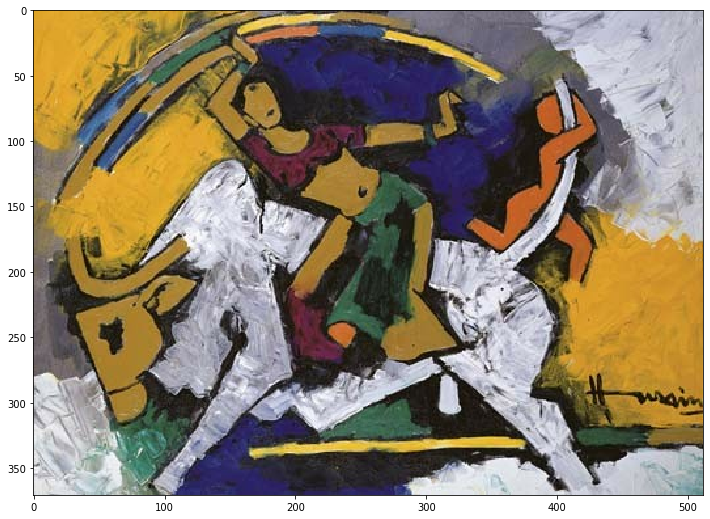

In [6]:
show_image(style_img)

In [8]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg=VGG19(include_top=False,weights='imagenet')
#for i in vgg.layers():
#    print(i.name)

In [9]:
#number and types of layers in the vgg19 model
for l in vgg.layers:
    print(l.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
content_capturing_layer=['block5_conv1']
style_capturing_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

In [10]:
#define a model from keras functional api which resemble to the already trained VGG19 
from tensorflow.keras.applications.vgg19 import VGG19
def model_(layer_names):
    vgg=VGG19(include_top="False",weights='imagenet')
    vgg.trainable='False'
    layer_outputs=[vgg.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg.input],layer_outputs)
    return output

In [13]:
style_extracting_model=model_(style_capturing_layers)
style_outputs=style_extracting_model(style_img*255)
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", style_outputs.numpy().shape)
    print("  min: ", style_outputs.numpy().min())
    print("  max: ", style_outputs.numpy().max())
    print("  mean: ", style_outputs.numpy().mean())
    print()

574717952/574710816 [==============================] - 1696s 3us/step


NameError: name 'output' is not defined

In [ ]:
#gram matrix for calculating style function;
def gram_matrix(input_tensor_value):
    result=tf.linalg.einsum('bijc,bijd->bcd',input_tensor_value,input_tensor-value)
    dimensions=tf.shape(input_tensor_value)
    mean=tf.cast(dimensions[1]*dimensions[2],ft.float32)
    return result/mean

In [ ]:
class style_content_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = model_(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    def call(self,inputs):
        inputs=inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}


In [ ]:
extractor = style_content_model(style_capturing_layers, content_capturing_layers)
results = extractor(tf.constant(content_img))

style_results = results['style']

print('Style_results')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Content_results")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

In [ ]:
style_targets=extractor(style_img)['style']
content_targets=extractor(content_img)['content']

image=tf.Variable(content_img)


In [ ]:
#clipping function for the image
def clip_0_1(image):
    return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)

In [ ]:
opt=tf.optimizers.Adam(learning_rate=0.02,beta_1=0.09,epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs=outputs['style']
    content_output=outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
def train_step(image):
    with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))